In [1]:
import datetime
import random
import os
import logging
import requests

In [2]:
import numpy as np
import pandas as pd
import h5py as h5
import multiprocess as mp
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Unit import *

In [4]:
%matplotlib inline

# Primitive Device Charaterization

Characterize Transistor Models with [PySpice](https://pyspice.fabrice-salvaire.fr/).

## Setup

In [5]:
lib_path    = 'lib'
model_base  = '90nm_bulk'
model_file  = f'{model_base}.lib'
model_url   = f'http://ptm.asu.edu/modelcard/2006/{model_base}.pm'
device_name = 'nmos'
data_file   = f'{model_base}.h5'
data_path   = 'data'
column_path = 'columns'
pool_size   = 6

In [6]:
temperature = 27
VSS         = 0.0
VDD         = 1.2
step_DC     = 0.01
min_VB      = -1.0
step_VB     = -0.1
min_W       = 1e-6
max_W       = 75e-6
num_W       = 10
min_L       = 150e-9
max_L       = 10e-6
num_L       = 10

### Device Model

For demonstration, ASU's 90nm Predictive Technology Model ([PTM](http://ptm.asu.edu/)) will be used and downloaded if not present.

In [7]:
def setup_library (path, model, url):
    model_path = f'./{path}/{model}'

    if not os.path.isfile(model_path):
        if not os.path.isdir(f'./{path}'):
            os.mkdir(f'./{path}')

        with open(model_path, "wb") as device_model:
            req = requests.get(url, allow_redirects=True)
            device_model.write(req.content)

    return f'./{path}'

In [8]:
lib = SpiceLibrary(setup_library(lib_path, model_file, model_url))

### Testbench

Set up the characterization test bench.

In [9]:
ckt = Circuit('Primitive Device Characterization')

ckt.include(lib[device_name])

Vd = ckt.V('d', 'D', ckt.gnd, u_V(0))
Vg = ckt.V('g', 'G', ckt.gnd, u_V(0))
Vb = ckt.V('b', 'B', ckt.gnd, u_V(0))

M0 = ckt.MOSFET(0, 'D', 'G', ckt.gnd, 'B', model=device_name)

### Parameters

Specify the parameters that SPICE will save.

In [10]:
column_names = [ 'W',   'L' 
               , 'Vds', 'Vgs', 'Vbs', 'vth', 'vdsat'
               , 'id',  'gbs', 'gbd', 'gds', 'gm', 'gmbs'
               , 'cbb', 'csb', 'cdb', 'cgb'
               , 'css', 'csd', 'csg', 'cds' 
               , 'cdd', 'cdg', 'cbs', 'cbd'
               , 'cbg', 'cgd', 'cgs', 'cgg' ]

save_params = [ f'@M0[{p.lower()}]' for p in column_names ]

### Simulator

Setup the simulator with the corret `temperature` and `save parameters` as specified earlier.

In [11]:

simulator = ckt.simulator( temperature=temperature
                         , nominal_temperature=temperature )

simulator.save_internal_parameters(*save_params)

A separate function is required for simulating in parallel.

In [12]:
def sim_dc(W, L, Vbs):
    M0.w = W
    M0.l = L
    Vb.dc_value = u_V(Vbs)

    analysis = simulator.dc( vd=slice(VSS, VDD, step_DC)
                           , vg=slice(VSS, VDD, step_DC))

    run_data = pd.DataFrame( { p[0]: analysis[p[1]].as_ndarray() 
                               for p in zip(column_names, save_params) } )

    return run_data

Setup the sweep grid.

In [13]:
sweep = [ (w,l,vbs) 
          for vbs in np.arange(0.0    , -1.0  , step=-0.1)
          for l in np.linspace(150e-9 , 10e-6 , num=10)
          for w in np.linspace(1e-6   , 75e-6 , num=10) ]

### Simulation

Run simulations for all input parameter combinations. Logging is disabled, because PySpice spams a warning about admittance not having a unit.

In [14]:
logging.disable(logging.FATAL)
with mp.Pool(pool_size) as pool:
    res = tqdm( pool.imap( func=lambda s: sim_dc(*s)
                         , iterable=sweep )
              , total = len(sweep) )
    results = list(res)
logging.disable(logging.NOTSET)

100%|██████████| 1000/1000 [00:42<00:00, 23.47it/s]


Concatenate the results of all simulation runs.

In [15]:
sim_res = pd.concat(results, ignore_index=True)

Store data in HDF5 binary.

In [16]:
with h5.File(data_file, 'w') as h5_file:
    h5_file[data_path] = sim_res.to_numpy()
    h5_file[column_path] = list(sim_res.columns)

## Plot Results

After chracterization, check out some of the results. First the terminal voltages are rounded for easier filtering.

In [17]:
sim_res.Vgs = round(sim_res.Vgs, ndigits=2)
sim_res.Vds = round(sim_res.Vds, ndigits=2)
sim_res.Vbs = round(sim_res.Vbs, ndigits=2)

Extract a random trace.

In [18]:
traces = sim_res[ (sim_res.Vbs == VSS) 
               & (sim_res.W == random.choice(sim_res.W.unique())) 
               & (sim_res.L == random.choice(sim_res.L.unique())) ]

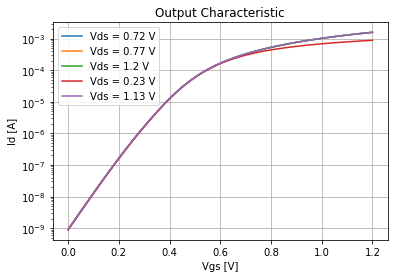

In [19]:
for v in random.sample(list(traces.Vds.unique()), 5):
    trace = traces[(traces.Vds == v)]
    plt.plot(trace.Vgs, trace.id, label = f'Vds = {v} V')
plt.grid()
plt.yscale('log')
plt.xlabel('Vgs [V]')
plt.ylabel('Id [A]')
plt.title('Output Characteristic')
plt.legend()

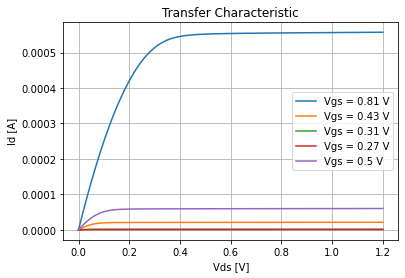

In [20]:
for v in random.sample(list(traces.Vgs.unique()), 5):
    trace = traces[(traces.Vgs == v)]
    plt.plot(trace.Vds, trace.id, label = f'Vgs = {v} V')
plt.grid()
plt.xlabel('Vds [V]')
plt.ylabel('Id [A]')
plt.title('Transfer Characteristic')
plt.legend()